In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pprint
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


# EXPLORATORY DATA ANALYSIS (EDA)

## 1. Read file

In [2]:
df = pd.read_csv("/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv")

## 2. Updated Metadata

In [3]:
metadata_dict = {
'loan_id'        : 'loan ID number',
'dependents'     : 'number of dependents',
'education'      : 'education status (graduate/not graduate)',
'self_employed'  : 'self-employed status',
'annual_income'  : 'self-reported annual income',
'loan_amount'    : 'loan amount',
'loan_term'      : 'loan term in year',
'credit_score'   : 'credit score (Indian cibil score system, range 300-900)',
'residential_av' : 'residential assets value',
'commercial_av'  : 'commercial assets value',
'luxury_av'      : 'luxury assets value',
'bank_av'        : 'bank assets value',
'loan_status'    : 'loan status (approved/rejected)'
}

## 3. Name change

In [4]:
df.columns = ['loan_id', 'dependents', 'education', 'self_employed', 'annual_income', 'loan_amount', 'loan_term', 
              'credit_score', 'residential_av', 'commercial_av', 'luxury_av', 'bank_av', 'loan_status']

In [5]:
df.head(2)

,loan_id,dependents,education,self_employed,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected


In [6]:
for col in df.columns:
    pprint.pprint(col)

'loan_id'
'dependents'
'education'
'self_employed'
'annual_income'
'loan_amount'
'loan_term'
'credit_score'
'residential_av'
'commercial_av'
'luxury_av'
'bank_av'
'loan_status'


## 4. Remove whitespaces

In [7]:
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

## 5. Information, data types, data shape, null data

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   loan_id         4269 non-null   int64 
 1   dependents      4269 non-null   int64 
 2   education       4269 non-null   object
 3   self_employed   4269 non-null   object
 4   annual_income   4269 non-null   int64 
 5   loan_amount     4269 non-null   int64 
 6   loan_term       4269 non-null   int64 
 7   credit_score    4269 non-null   int64 
 8   residential_av  4269 non-null   int64 
 9   commercial_av   4269 non-null   int64 
 10  luxury_av       4269 non-null   int64 
 11  bank_av         4269 non-null   int64 
 12  loan_status     4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [9]:
print(f"Duplicated data: {df.duplicated().sum()}")
print(f"Data shape: {df.shape}")
print(f"Null data: {df.isnull().sum().sum()}")

Duplicated data: 0
Data shape: (4269, 13)
Null data: 0


## 6. Data statistics

In [10]:
df.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
loan_id,4269.0,2135.0,1232.5,1.0,1068.0,2135.0,3202.0,4269.0
dependents,4269.0,2.5,1.7,0.0,1.0,3.0,4.0,5.0
annual_income,4269.0,5059123.9,2806839.8,200000.0,2700000.0,5100000.0,7500000.0,9900000.0
loan_amount,4269.0,15133450.5,9043363.0,300000.0,7700000.0,14500000.0,21500000.0,39500000.0
loan_term,4269.0,10.9,5.7,2.0,6.0,10.0,16.0,20.0
credit_score,4269.0,599.9,172.4,300.0,453.0,600.0,748.0,900.0
residential_av,4269.0,7472616.5,6503636.6,-100000.0,2200000.0,5600000.0,11300000.0,29100000.0
commercial_av,4269.0,4973155.3,4388966.1,0.0,1300000.0,3700000.0,7600000.0,19400000.0
luxury_av,4269.0,15126305.9,9103753.7,300000.0,7500000.0,14600000.0,21700000.0,39200000.0
bank_av,4269.0,4976692.4,3250185.3,0.0,2300000.0,4600000.0,7100000.0,14700000.0


## 7. Quick look at Loan IDs

In [11]:
df.head(2)

,loan_id,dependents,education,self_employed,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected


In [12]:
print(f"There are {df['loan_id'].nunique()} unique loan IDs, each ID represent each row of the data frame with a size of {df.shape}.")

There are 4269 unique loan IDs, each ID represent each row of the data frame with a size of (4269, 13).


## 8. Drop 'loan_id' column

**We will not be using loan_id for furthur analysis.**

In [13]:
df.drop('loan_id', axis=1, inplace=True)

In [14]:
df.head(2)

,dependents,education,self_employed,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected


## 9. Explore each feature through visualization

In [15]:
for col in df.columns:
    print(f"\n'{col}'")
    
    # print unique values for columns that have 10 or less unique values count:
    if df[col].nunique() <= 10:
        
        # print all unique value count:
        print(f"\t unique value count: {df[col].nunique()}")
        
        # print unique values:
        print(f"\t unique values: {df[col].unique()}")
        
        # create pie chart for columns with 2 or less unique values count:
        if df[col].nunique() <= 2:
            fig = px.pie(names=df[col].groupby(by=df[col]).count().index, 
                         values=df[col].groupby(by=df[col]).count().values, 
                         width=600, height=400)
            fig.update_traces(text=df[col].groupby(by=df[col]).count().values, textposition='inside')
            fig.show()
        
        # create bar chart for columns with more than 2 unique values count:
        elif df[col].nunique() > 2:
            fig = px.bar(x=df[col].groupby(by=df[col]).count().index, 
                         y=df[col].groupby(by=df[col]).count().values, 
                         labels={'x':col, 'y':'count / frequency'}, 
                         width=600, height=400)
            fig.update_traces(text=df[col].groupby(by=df[col]).count().values, textposition='inside')
            fig.update_layout(xaxis=dict(tickmode='array', 
                                         tickvals=df[col].groupby(by=df[col]).count().index, 
                                         ticktext=df[col].groupby(by=df[col]).count().index))
            fig.show()
    
    # create histogram for columns with more than 10 unique values and less than or equal to the data length of 4269:
    elif df[col].nunique() > 10 and df[col].nunique() <= len(df):
        
        # print mean and standard deviation of the column:
        print(f"\tStandard deviation: {df[col].std().round(2)}")
        print(f"\tMean: {df[col].mean().round(2)}")
        
        fig = px.histogram(df, x=col)
        fig.update_layout(xaxis_title = col, yaxis_title = 'count / frequency', 
                          width=600, height=400)
        fig.show()
    
    print("\n"+("-"*80))


'dependents'
	 unique value count: 6
	 unique values: [2 0 3 5 4 1]



--------------------------------------------------------------------------------

'education'
	 unique value count: 2
	 unique values: ['Graduate' 'Not Graduate']



--------------------------------------------------------------------------------

'self_employed'
	 unique value count: 2
	 unique values: ['No' 'Yes']



--------------------------------------------------------------------------------

'annual_income'
	Standard deviation: 2806839.83
	Mean: 5059123.92



--------------------------------------------------------------------------------

'loan_amount'
	Standard deviation: 9043362.98
	Mean: 15133450.46



--------------------------------------------------------------------------------

'loan_term'
	 unique value count: 10
	 unique values: [12  8 20 10  4  2 18 16 14  6]



--------------------------------------------------------------------------------

'credit_score'
	Standard deviation: 172.43
	Mean: 599.94



--------------------------------------------------------------------------------

'residential_av'
	Standard deviation: 6503636.59
	Mean: 7472616.54



--------------------------------------------------------------------------------

'commercial_av'
	Standard deviation: 4388966.09
	Mean: 4973155.31



--------------------------------------------------------------------------------

'luxury_av'
	Standard deviation: 9103753.67
	Mean: 15126305.93



--------------------------------------------------------------------------------

'bank_av'
	Standard deviation: 3250185.31
	Mean: 4976692.43



--------------------------------------------------------------------------------

'loan_status'
	 unique value count: 2
	 unique values: ['Approved' 'Rejected']



--------------------------------------------------------------------------------


## 10. Data correlation and matrix heatmap

In [16]:
df_corr = df.corr(numeric_only=True) #default method: pearson

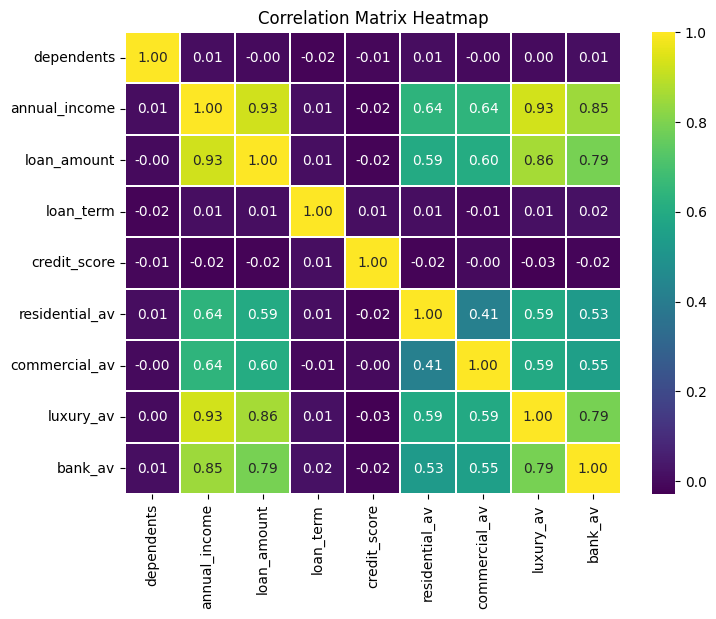

In [17]:
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='viridis', fmt='.2f', linewidths=0.01)
plt.title("Correlation Matrix Heatmap")
plt.show()

## 11. Let's take a look at feature pairs with high correlation score (>0.5)

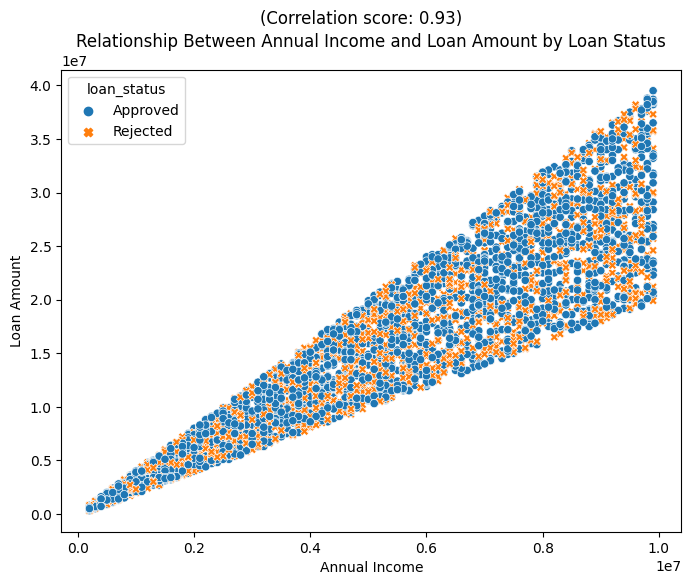

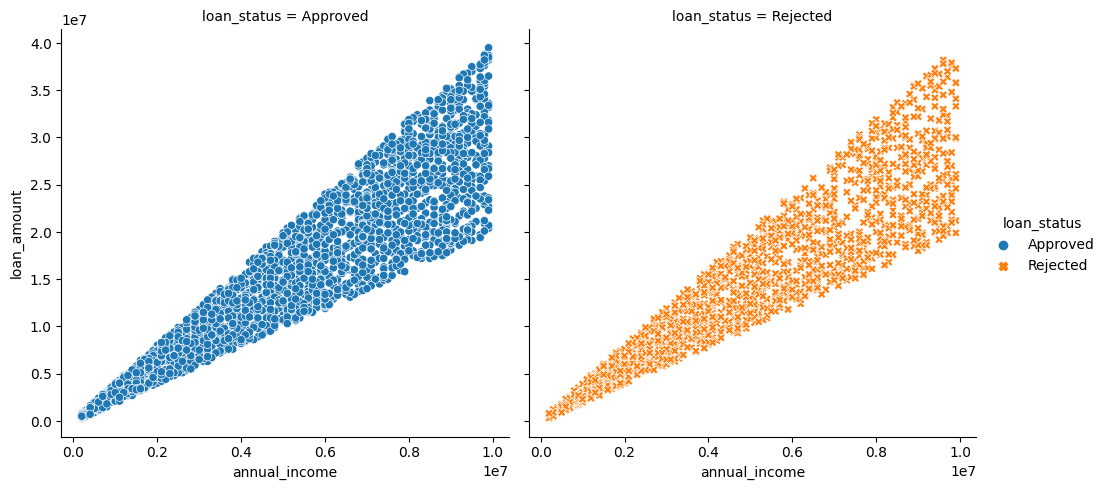

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df, x='annual_income', y='loan_amount', hue='loan_status', style='loan_status')
plt.title('Relationship Between Annual Income and Loan Amount by Loan Status')
plt.suptitle("(Correlation score: 0.93)")
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.show()

sns.relplot(df, x="annual_income", y="loan_amount", col="loan_status", hue="loan_status", style="loan_status", kind="scatter")
plt.show()

## 12. Relationship between Loan Amount/Annual Income and Combined Assets Value

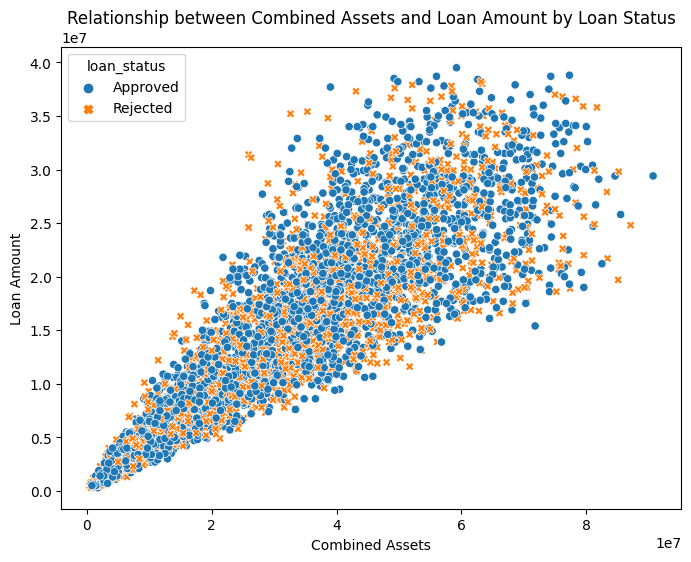

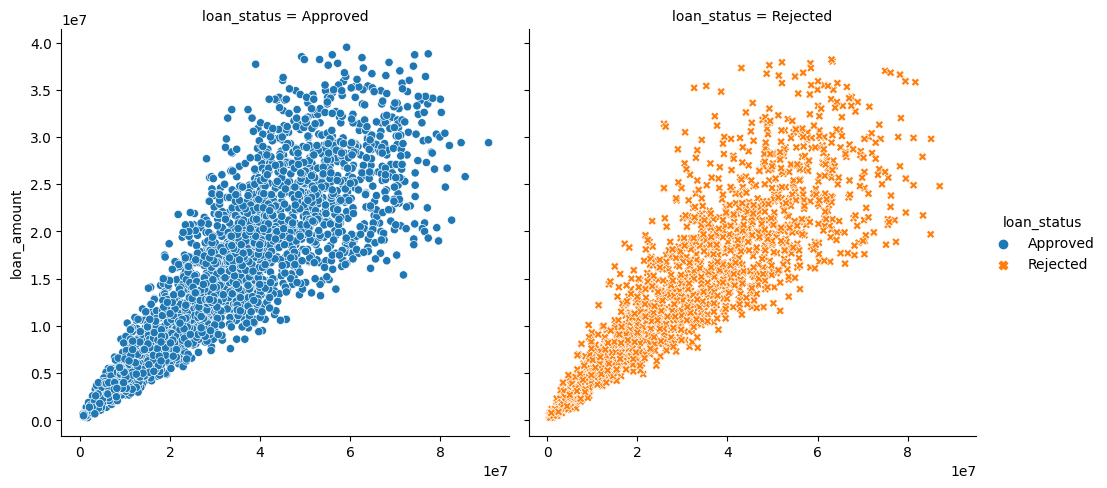


------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------



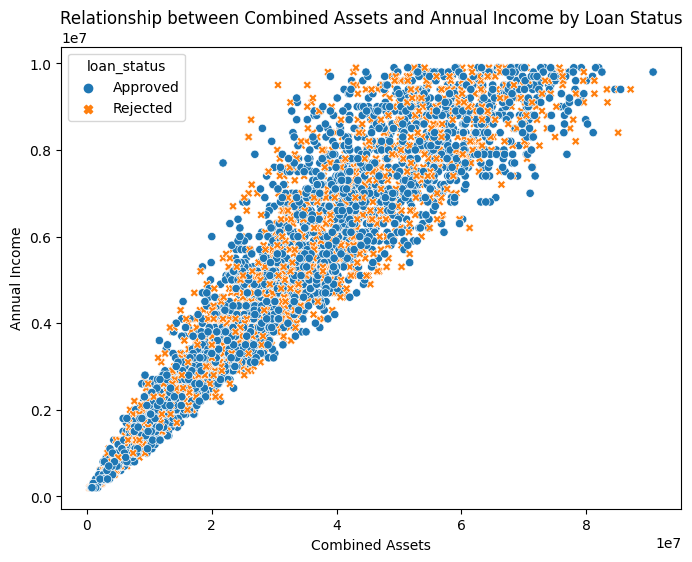

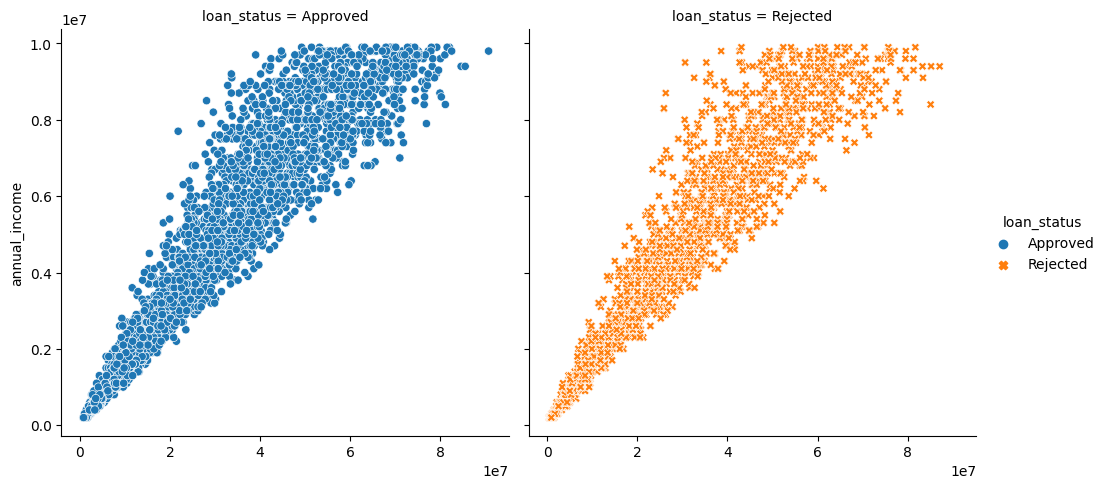


------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------



In [19]:
combined_av = df.apply(lambda row: row['residential_av']+row['commercial_av']+row['bank_av']+row['luxury_av'], axis=1)
for col, name in {'loan_amount':'Loan Amount', 'annual_income':'Annual Income'}.items():
    plt.figure(figsize=(8,6))
    sns.scatterplot(df, x=combined_av, y=col, hue='loan_status', style='loan_status')
    plt.title(f"Relationship between Combined Assets and {name} by Loan Status")
    plt.xlabel('Combined Assets')
    plt.ylabel(name)
    plt.show()
    sns.relplot(df, x=combined_av, y=col, col="loan_status", hue="loan_status", style="loan_status", kind="scatter")
    plt.show()
    print("\n" + "-"*138)
    print("-"*138 + "\n")

## 13. Loan term count by loan status

In [20]:
# Calculate counts for each combination of loan_term and loan_status
count_term_status = df.groupby(['loan_term', 'loan_status']).size().reset_index(name='count')

# Calculate total counts for each loan_term
total_counts = count_term_status.groupby('loan_term')['count'].sum().reset_index(name='total_count')

# Merge total counts with the count_term_status to calculate percentages
count_term_status = count_term_status.merge(total_counts, on='loan_term')
count_term_status['percentage'] = (count_term_status['count'] / count_term_status['total_count'] * 100).round(0).astype(int)

#create a string of value of percentage
count_term_status['count_percentage'] = count_term_status['count'].astype(str).str.cat(count_term_status['percentage'].astype(str), sep='<br>(') + '%)'

In [21]:
# Create a bar chart
fig = px.bar(count_term_status, x='loan_term', y='count', color='loan_status', text='count_percentage', width=700, height=500)

# Update x labels
fig.update_xaxes(tickangle=0, tickmode='array', tickvals=count_term_status['loan_term'], ticktext=count_term_status['loan_term'])

# Update layout for better visual appearance
fig.update_layout(xaxis_title = 'Loan Term in Year', 
                  yaxis_title = 'Count', 
                  title = {"text":"Loan Term Count by Status", 
                           "font":{'size': 18, 'color': 'black', 'weight':'bold'}, 
                           "x":0.5, 
                           "xanchor": "center"})

# Update traces to show text labels inside the bars with bold font
fig.update_traces(texttemplate='%{text}', 
                  textposition='inside', 
                  textfont=dict(size=9, color="white", weight="normal"))

# Add total count labels as an additional trace
for _, row in total_counts.iterrows():
    fig.add_annotation(
        x=row['loan_term'],
        y=row['total_count'],
        text=f"{row['total_count']}",
        showarrow=False,
        yshift=10,
        font=dict(size=10, color="black", weight="bold"),
        align="center")

# Show the figure
fig.show()

* **Applicants are more likely to get approved (with over 80% chances) with shorter loan terms (2-4 years).**

* **For loans with term of 6 years or more, average chances are 57/43 of gettin approved or denied, still more lilely to get approved.**

## 14. Histograms for Loan Amount, Annual Income, and Credit Score by Loan Status

In [22]:
# Histograms for Loan Amount, Annual Income, and Credit Score by Loan Status
for col in df[['loan_amount', 'annual_income', 'credit_score']]:
    fig = px.histogram(df, x=col, color='loan_status', width=800, height=600)
    fig.show()

* **Credit score of 560 and above have significant chances of getting approved (most likely approved, 95% chances).**
* **50/50 chance for credit score between 540 to 559.**
* **Average 15% approval chane for credit score under 540.**

<hr>
<hr>
<hr>
<hr>
<hr>

# MACHINE LEARNING MODELS

Summary:
* Encode categorical features to 1 and 0
* Scale numerical features using Robust Scaler

## 1. Data Pre-processing and Encoding

In [23]:
# Convert loan tearm in years to days:
df['loan_term'] = df['loan_term']*365

In [24]:
categorical_features = ['education', 'self_employed', 'loan_status']
categorical_df = df[categorical_features]

In [25]:
def encoder(dataframe, features):
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(dataframe)
    encoded_dataframe = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())
    return encoded_dataframe

In [26]:
encoded_df = encoder(categorical_df, categorical_features)
encoded_df.head(2)

,education_Graduate,education_Not Graduate,self_employed_No,self_employed_Yes,loan_status_Approved,loan_status_Rejected
0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0


In [27]:
encoded_df = encoded_df[['education_Graduate','self_employed_Yes','loan_status_Approved']]
encoded_df.head(2)

,education_Graduate,self_employed_Yes,loan_status_Approved
0,1.0,0.0,1.0
1,0.0,1.0,0.0


In [28]:
# Make a copy from original df and assign it to df_w_encode
df_w_encode = df.copy()
# Replace catergorical data with encoding data from encoded_df
df_w_encode[categorical_features] = encoded_df
# Show:
df_w_encode.head(2)

,dependents,education,self_employed,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,loan_status
0,2,1.0,0.0,9600000,29900000,4380,778,2400000,17600000,22700000,8000000,1.0
1,0,0.0,1.0,4100000,12200000,2920,417,2700000,2200000,8800000,3300000,0.0


## 3. Data Scaling

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

**Since financial data like annual income and asset values can often have outliers, using RobustScaler may be more effective because it focuses on the interquartile range.**

In [29]:
numerical_features = ['annual_income', 'loan_amount', 'loan_term', 'credit_score', 
                      'residential_av', 'commercial_av', 'luxury_av', 'bank_av']
df_w_numerical = df_w_encode[numerical_features]

In [30]:
rb_scaler = RobustScaler(quantile_range=(20,80))  # default quantile_range=(25,75)
rb_scaler.fit(df_w_numerical)

RobustScaler(quantile_range=(20, 80))

In [31]:
# bring scaled data into dataframe
df_w_numerical_scaled = pd.DataFrame(rb_scaler.transform(df_w_numerical), columns=df_w_numerical.columns)
# Make a copy
df_w_encode_numerical_scaled = df_w_encode.copy()
# Assign the scaled features back to the dataframe with encode
df_w_encode_numerical_scaled[numerical_features] = df_w_numerical_scaled[numerical_features]

In [32]:
df_w_encode_numerical_scaled.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
dependents,4269.0,2.5,1.7,0.0,1.0,3.0,4.0,5.0
education,4269.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
self_employed,4269.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
annual_income,4269.0,-0.0,0.5,-0.8,-0.4,0.0,0.4,0.8
loan_amount,4269.0,0.0,0.5,-0.8,-0.4,0.0,0.4,1.5
loan_term,4269.0,0.1,0.6,-0.8,-0.4,0.0,0.6,1.0
credit_score,4269.0,-0.0,0.5,-0.8,-0.4,0.0,0.4,0.8
residential_av,4269.0,0.2,0.6,-0.5,-0.3,0.0,0.5,2.1
commercial_av,4269.0,0.2,0.6,-0.5,-0.3,0.0,0.5,2.0
luxury_av,4269.0,0.0,0.5,-0.8,-0.4,0.0,0.4,1.4


In [33]:
# dataframe use to train models

df_w_encode_numerical_scaled.head(2)

,dependents,education,self_employed,annual_income,loan_amount,loan_term,credit_score,residential_av,commercial_av,luxury_av,bank_av,loan_status
0,2,1.0,0.0,0.775862,0.895349,0.2,0.498599,-0.282187,1.782051,0.468208,0.576271,1.0
1,0,0.0,1.0,-0.172414,-0.133721,-0.2,-0.512605,-0.255732,-0.192308,-0.335260,-0.220339,0.0


## 2. Data splitting for training and testing

In [34]:
x = df_w_encode_numerical_scaled.drop('loan_status', axis=1)
y = df_w_encode_numerical_scaled['loan_status']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28, stratify=y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3415, 11) (854, 11) (3415,) (854,)


## 4. ML Models and result comparation

In [35]:
ml_models = [("eXtremGradientBoosting" , XGBClassifier()),  
             ("GradientBoosting" , GradientBoostingClassifier()), 
             ("RandomForest" , RandomForestClassifier()), 
             ("DecisionTree" , DecisionTreeClassifier())]

In [36]:
for model in ml_models:
    print(model[0]+": ")
    model[1].fit(x_train, y_train)
    y_pred = model[1].predict(x_test)
    print('\troc_auc_score ',round(roc_auc_score(y_pred, y_test),3))
    print('\tf1_score ',round(f1_score(y_pred, y_test),3))
    print("\n" + classification_report(y_pred, y_test))
    print("-"*60 + "\n")

eXtremGradientBoosting: 
	roc_auc_score  0.988
	f1_score  0.991

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       321
           1       0.99      0.99      0.99       533

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854

------------------------------------------------------------

GradientBoosting: 
	roc_auc_score  0.983
	f1_score  0.988

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       326
         1.0       0.98      0.99      0.99       528

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

------------------------------------------------------------

RandomForest: 
	roc_auc_score  0.985
	f1_score  0.988

              precision    recall  f1-score

<hr>
<hr>
<hr>
<hr>
<hr>

In [37]:
model = XGBClassifier()

In [38]:
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
y_pred = model.predict(x_test)
print('\troc_auc_score ',round(roc_auc_score(y_pred, y_test),3))
print('\tf1_score ',round(f1_score(y_pred, y_test),3))
print("\n" + classification_report(y_pred, y_test))

	roc_auc_score  0.988
	f1_score  0.991

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       321
           1       0.99      0.99      0.99       533

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854



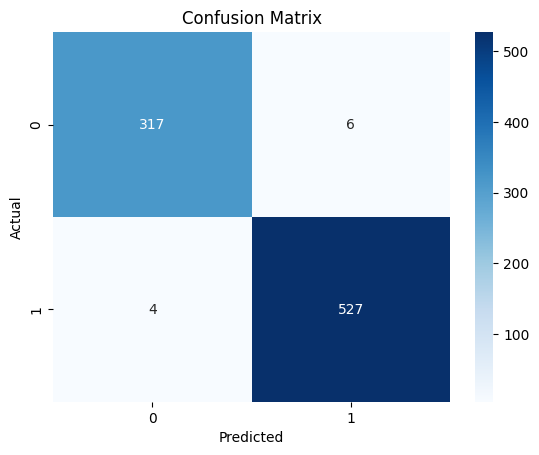

In [40]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# HYPERPARAMETERS TUNING AND PERFORM GRIDSEARCHCV

In [41]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'learning_rate': [0.1, 0.01, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.1, 0.2], 
    'subsample': [0.8, 1.0], 
    'colsample_bytree': [0.8, 1.0]
}

In [42]:
# Initialize GridSearchCV
# Set n_jobs=-1 in GridSearchCV or RandomizedSearchCV to use all available CPU cores.
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', return_train_score=True, n_jobs=-1)

In [43]:
# Fit GridSearchCV on the training data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.2],
                         'max_depth': [3, 5, 7, 9],
                         'min_child_weight': [1, 3, 5, 7],
                         'n_estimators': [10, 25, 50],
                         'subsample': [0.8, 1.0]},
             return_train_score=True, scoring='accuracy')

In [44]:
# Get the best parameters and the best model
best_params = grid_search.best_params_
# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 1.0}


In [45]:
better_model = XGBClassifier(colsample_bytree=1.0, 
                             gamma=0.1, 
                             learning_rate=0.2, 
                             max_depth=7, 
                             min_child_weight=1,
                             n_estimators=50, 
                             subsample=1.0)

In [46]:
better_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
better_y_pred = better_model.predict(x_test)
print('\troc_auc_score ',round(roc_auc_score(better_y_pred, y_test),3))
print('\tf1_score ',round(f1_score(better_y_pred, y_test),3))
print("\n" + classification_report(better_y_pred, y_test))

	roc_auc_score  0.988
	f1_score  0.992

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       326
           1       0.99      0.99      0.99       528

    accuracy                           0.99       854
   macro avg       0.99      0.99      0.99       854
weighted avg       0.99      0.99      0.99       854



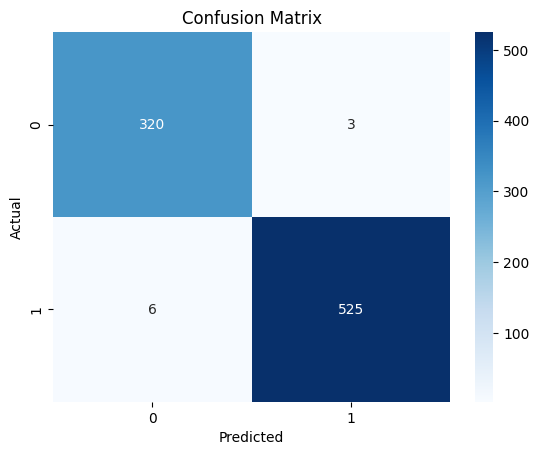

In [48]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, better_y_pred)

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [49]:
forest_importances = pd.Series(better_model.feature_importances_, index=x_train.columns)
forest_importances.sort_values(ascending=False)

credit_score      0.715764
loan_term         0.182518
loan_amount       0.022995
annual_income     0.021248
residential_av    0.011847
luxury_av         0.010450
commercial_av     0.008647
dependents        0.008513
bank_av           0.007085
education         0.006966
self_employed     0.003967
dtype: float32

<hr>
<hr>
<hr>
<hr>
<hr>

# MODEL DEPLOYMENT

In [50]:
# Install streamlit (quiet mode -q)
!pip install streamlit -q

In [51]:
import streamlit as st
import joblib

In [52]:
joblib.dump(better_model, 'loan_approval_model.pkl')

['loan_approval_model.pkl']

In [53]:
joblib.dump(rb_scaler, 'rb_scaler.pkl')

['rb_scaler.pkl']

## Write python app file

In [54]:
%%writefile app.py


import streamlit as st
import joblib
import xgboost as xgb
import pandas as pd


Model = joblib.load("loan_approval_model.pkl")
Scaler = joblib.load("rb_scaler.pkl")


numerical_cols = ['annual_income', 'loan_amount', 'loan_term', 'credit_score', 
                  'residential_av', 'commercial_av', 'luxury_av', 'bank_av']


def predict(dependents, education , self_employed, annual_income, loan_amount, loan_term, credit_score, 
            residential_av, commercial_assets_value, luxury_av, bank_av):
    test_df = pd.DataFrame(columns = ['dependents', 'education', 'self_employed', 'annual_income', 
                                      'loan_amount', 'loan_term', 'credit_score', 'residential_av', 
                                      'commercial_av', 'luxury_av', 'bank_av'])
    test_df.at[0,'dependents'] = dependents
    test_df.at[0,'education'] = education
    test_df.at[0,'self_employed'] = self_employed
    test_df.at[0,'annual_income'] = float(annual_income)
    test_df.at[0,'loan_amount'] = float(loan_amount)
    test_df.at[0,'loan_term'] = float(loan_term) * 365
    test_df.at[0,'credit_score'] = float(credit_score)
    test_df.at[0,'residential_av'] = float(residential_av)
    test_df.at[0,'commercial_av'] = float(commercial_av)
    test_df.at[0,'luxury_av'] = float(luxury_av)
    test_df.at[0,'bank_av'] = float(bank_av)
    
    temp_df = pd.DataFrame(Scaler.transform(test_df[numerical_cols]),columns=numerical_cols)
    test_df.drop(numerical_cols, axis=1, inplace=True)
    test_df = pd.concat([test_df, temp_df], axis=1)
    test_df.dependents = test_df.dependents.astype(int)
    test_df.education = test_df.education.astype(int)
    test_df.self_employed = test_df.self_employed.astype(int)
    print(test_df.dtypes)
    result = Model.predict(test_df)[0]
    return result


# Streamlit app
st.title("Loan Approval Prediction")
st.header("Enter Loan Details")
dependents = st.slider("Number of dependents", min_value=0, max_value=5, value=0, step=1)
education = int(st.selectbox("Education" ,[0 , 1]))
self_employed = int(st.selectbox("self_employed" , [0 , 1]))
annual_income = st.slider("Annual Income", min_value=200000, max_value=9900000, value=200000, step=1000)
loan_amount = st.slider("Loan Amount" , min_value=300000, max_value=39500000, value=300000, step=10000)
loan_term = st.slider("Loan Term", min_value=2, max_value=20, value=2, step=1)
credit_score = st.slider("Credit Score" , min_value=300, max_value=900, value=300, step=1)
residential_av = st.slider("Residential AV", min_value=-100000, max_value=29100000, value=0, step=10000)
commercial_av = st.slider("Commerical AV", min_value=0, max_value=19400000, value=0, step=1000)
luxury_av = st.slider("Luxury AV", min_value=300000, max_value=39200000, value=300000, step=10000)
bank_av = st.slider("Bank AV", min_value=0, max_value=14700000, value=0, step=10000)


input_data = pd.DataFrame({
    'dependents': [dependents],
    'education': [education],
    'self_employed': [self_employed],
    'annual_income': [annual_income],
    'loan_amount': [loan_amount],
    'loan_term': [loan_term],
    'credit_score': [credit_score],
    'residential_av': [residential_av],
    'commercial_av': [commercial_av],
    'luxury_av': [luxury_av],
    'bank_av': [bank_av]
})


# Predict loan approval
if st.button("Predict"):
        result = predict(dependents, 
                         education, 
                         self_employed, 
                         annual_income, 
                         loan_amount, 
                         loan_term, 
                         credit_score, 
                         residential_av, 
                         commercial_av, 
                         luxury_av, 
                         bank_av)
        label = ["rejected","approved"]
        st.markdown("## The application is **{}**.".format(label[result]))

Writing app.py


In [55]:
# Install localtunnel@2.0.2 (quiet mode -q)
!npm install -g localtunnel@2.0.2 -q


added 22 packages in 2s

3 packages are looking for funding
  run `npm fund` for details
npm notice 
npm notice New minor version of npm available! 10.5.0 -> 10.8.3
npm notice Changelog: https://github.com/npm/cli/releases/tag/v10.8.3
npm notice Run npm install -g npm@10.8.3 to update!
npm notice 


In [56]:
#copy this series of number and use it for the prompt in the url below
!wget -q -O - ipv4.icanhazip.com

34.145.42.41


## Run Demo

* **Remove '#' below and follow URL**

In [57]:
#! streamlit run app.py & npx localtunnel --port 8501